In [1]:
from collections import defaultdict
import re
import pandas as pd
import numpy as np
from scipy import stats
from scipy import cluster
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
genete_annot = pd.read_csv('../data/gffs/danRer11.nonalt.genes_tes.gtf', sep='\t', header=None)
genete_annot = genete_annot.loc[genete_annot[2] == 'exon']
genete_annot['len'] = abs(genete_annot[3] - genete_annot[4])
genete_annot['gene'] = genete_annot[8].apply(lambda x: x.split()[3].strip(';').strip('"'))
genelengths = genete_annot[['gene', 'len']] \
    .groupby('gene') \
    .sum() \
    .reset_index()
genelengths = dict(zip(genelengths['gene'], genelengths['len']))

/Users/jonwells/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sample_df = pd.read_csv('../data/expression/White2017/elife-30860-supp1-v1.tsv', sep='\t')
sample_df = sample_df.rename({'accession_number': 'sampleAccession'}, axis=1)
print(sample_df)

           sample                public_name sampleAccession    condition  \
0     zmp_ph133_B        ZMP_phenotype_133_B      ERS1079239  ZFS:0000001   
1     zmp_ph133_D        ZMP_phenotype_133_D      ERS1079240  ZFS:0000001   
2     zmp_ph133_E        ZMP_phenotype_133_E      ERS1079241  ZFS:0000001   
3     zmp_ph133_F        ZMP_phenotype_133_F      ERS1079243  ZFS:0000001   
4     zmp_ph133_G        ZMP_phenotype_133_G      ERS1079244  ZFS:0000001   
..            ...                        ...             ...          ...   
508  zmp_ph122_E5  ZMP_phenotype_122_5dpf_E5       ERS626209  ZFS:0000037   
509  zmp_ph122_E6  ZMP_phenotype_122_5dpf_E6       ERS626210  ZFS:0000037   
510  zmp_ph122_E7  ZMP_phenotype_122_5dpf_E7       ERS626211  ZFS:0000037   
511  zmp_ph122_E8  ZMP_phenotype_122_5dpf_E8       ERS626212  ZFS:0000037   
512  zmp_ph122_E9  ZMP_phenotype_122_5dpf_E9       ERS626213  ZFS:0000037   

             stage stageName             sampleName sequencing  
0    Zygot

In [4]:
def load_counts(tecountsfile):
    accession = re.search('(ERS\d+)\.', tecountsfile).group(1)
    tecount_df = pd.read_csv(tecountsfile, skiprows=1, header=None, names=['gene', 'reads'], sep='\t')
    tecount_df['gene'] = tecount_df['gene'].apply(lambda x: x.split(':')[0])
    tecount_df[accession] = tecount_df['reads']
    return tecount_df[['gene', accession]]

accessions = {}
with open('../data/expression/White2017/sample_list.txt') as infile:
    accessions = {line.split()[0]: line.split()[1:] for line in infile}
    
countdata = []
for acc in accessions.keys():
    countdata.append(load_counts(f'../data/expression/TEcount-out/{acc}.inslt10kb.cntTable'))
counts_df = pd.concat(countdata, axis=1, join='inner') \
              .drop('gene', axis=1)
counts_df['gene'] = countdata[0]['gene']
print(counts_df.head())

   ERS1079138  ERS1079139  ERS1079140  ERS1079141  ERS1079142  ERS1079143  \
0           9          18          15          19          22          12   
1           5           2           1           0           3          52   
2         374         334         423         468         304         252   
3         673         735         798         679         648         505   
4         317         349         299         299         288          69   

   ERS1079144  ERS1079145  ERS1079146  ERS1079147  ...  ERS1079234  \
0          13          14          20          15  ...         110   
1          40          59          67          34  ...          14   
2         255         387         340         246  ...         996   
3         419         612         513         370  ...        1266   
4          79         101          83          59  ...         379   

   ERS1079235  ERS1079236  ERS1079238  ERS1079239  ERS1079240  ERS1079241  \
0          99          92          80  

In [5]:
tpm_df = counts_df.melt(id_vars='gene', var_name='sampleAccession', value_name='counts')
tpm_df = tpm_df.merge(sample_df[['sampleAccession', 'stageName', 'sequencing']], 
                                    on='sampleAccession', 
                                    how='left')
tpm_df = tpm_df.loc[tpm_df.sequencing == 'RNASeq']

tpm_df = tpm_df.groupby(['stageName', 'sequencing', 'gene']) \
    .median() \
    .reset_index() \
    .drop('sequencing', 1)

ascale = tpm_df.groupby('stageName')['counts'].sum()/1e06
ascale = dict(zip(ascale.reset_index().stageName, ascale.reset_index().counts))
tpm_df['len'] = tpm_df['gene'].apply(lambda x: genelengths[x])
tpm_df['rpk'] = tpm_df['counts']/(tpm_df['len']/1000)
tpm_df['ascale'] = tpm_df['stageName'].apply(ascale.get)
tpm_df['tpm'] = tpm_df['rpk']/tpm_df['ascale']
tpm_df = tpm_df.drop(['rpk', 'ascale', 'len', 'counts'], axis=1)


stageorder = ['1-cell', 
             '2-cell', 
             '128-cell', 
             '1k-cell', 
             'Dome', 
             '50pc-epiboly', 
             'Shield', 
             '75pc-epiboly', 
             '1-4-somites', 
             '14-19-somites', 
             '20-25-somites',
             'Prim-5',
             'Prim-15',
             'Prim-25',
             'Long-pec',
             'Protruding-mouth',
             'Day-4',
             'Day-5']
tpm_df['stageName'] = pd.Categorical(tpm_df['stageName'], stageorder)
tpm_df = tpm_df.sort_values(['gene', 'stageName'])

print(tpm_df.loc[tpm_df.gene == 'BHIKHARI_LTR'].head())

       stageName          gene       tpm
35422     1-cell  BHIKHARI_LTR  0.000643
176474    2-cell  BHIKHARI_LTR  0.003161
70685   128-cell  BHIKHARI_LTR  0.003094
141211   1k-cell  BHIKHARI_LTR  0.010410
388052      Dome  BHIKHARI_LTR  1.623501


In [17]:
finz = []
with open('../data/gffs/gffcmp.Danio_rerio_finz.denovo.gff.tmap') as infile:
    header = infile.readline()
    for line in infile:
        line = line.split()
        if line[0] == '-':
            finz.append(line[3])
        else:
            finz.append(line[0])
            
test = tpm_df.groupby(['gene'], as_index=False).max()
expressed = test.loc[(test.tpm > 10) & (test.gene.isin(finz)), 'gene'].to_list()
print(len(finz))
print(len(expressed))

817
97


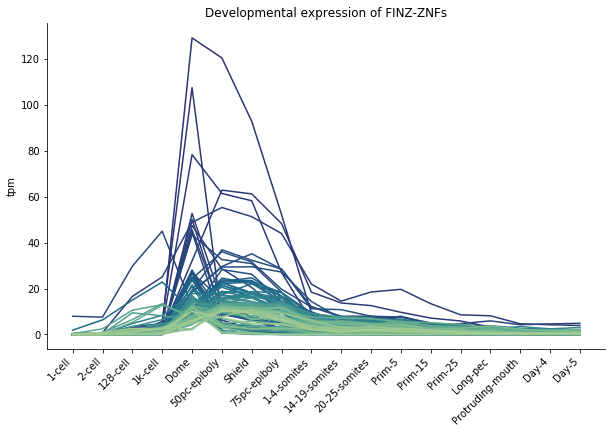

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

hue_order = list(tpm_df.loc[tpm_df.gene.isin(expressed)].groupby('gene').max().reset_index().sort_values('tpm')['gene'])

sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(expressed)],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='gene',
             hue_order=hue_order[::-1],
             palette='crest_r',
             lw=1.5,
             ax=ax)

ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

In [43]:
finz_matrix = tpm_df.loc[tpm_df['gene'].isin(finz)].set_index('gene')
finz_matrix['tpm1'] = np.log(finz_matrix['tpm'] + 1)
finz_matrix = finz_matrix[['tpm1', 'stageName']]
finz_matrix = finz_matrix.pivot(columns='stageName', values='tpm1')

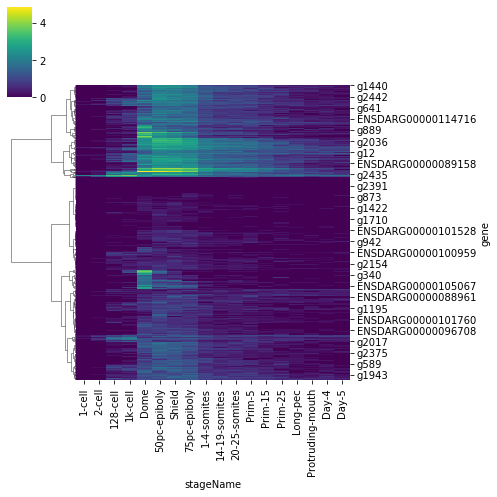

In [45]:
fig = sns.clustermap(data=finz_matrix, 
                     cmap="viridis", 
                     col_cluster=False,
#                      metric='euclidean',
                     method='ward',
                     figsize=(7, 7))
plt.show()

nclusts = 2
clusters = {}
for pair in zip(cluster.hierarchy.cut_tree(fig.dendrogram_row.linkage, nclusts), fig.dendrogram_row.reordered_ind):
    clusters[finz_matrix.index[pair[1]]] = pair[0][0]
tpm_df['cluster'] = tpm_df['gene'].apply(clusters.get)

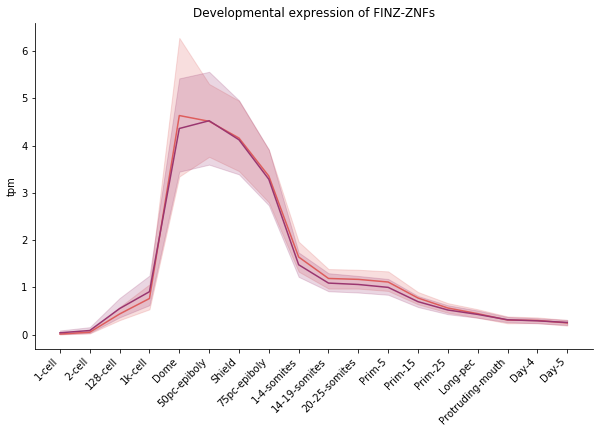

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
# g = sns.FacetGrid(tpm_df.loc[tpm_df.gene.isin(finz)])
sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(finz)],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='cluster',
             palette='flare',
             lw=1.5,
             ax=ax)

ax.set_title('Developmental expression of FINZ-ZNFs')
ax.get_legend().remove()
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

In [57]:
clades = {}
for i in [1, 2, 3, 4, 5]:
    with open(f'../data/selection-analysis/d2sk4_drer_clade{i}.taxa') as infile:
        clades[i] = [line.strip('.t1\n').strip('Danio_rerio_') for line in infile]


{1: ['g1003', 'g2282', 'g1665', 'g596', 'g775', 'g1130', 'g1415', 'g688', 'g1848', 'g749', 'g1137', 'g2503', 'g2415'], 2: ['g434', 'g106', 'g70', 'g65', 'g2454', 'g527', 'g267', 'g1054', 'g967', 'g987', 'g2344'], 3: ['g1423', 'g1840', 'g818', 'g2379', 'g680', 'g928', 'g943', 'g1615', 'g1867', 'g2285', 'g1450'], 4: ['g113', 'g137', 'g695', 'g1484', 'g2385', 'g203', 'g808', 'g1190', 'g1670', 'g1512', 'g228', 'g734', 'g1116', 'g1232', 'g2438', 'g329', 'g682', 'g2460', 'g259', 'g1604', 'g1023', 'g386', 'g727', 'g1184', 'g1708', 'g235', 'g284', 'g238', 'g1560', 'g1927', 'g1196', 'g537', 'g589', 'g2388', 'g926', 'g2373', 'g150', 'g834', 'g1357', 'g1685', 'g2499', 'g1348', 'g798', 'g2502', 'g1470', 'g1296', 'g1075', 'g1719', 'g107', 'g1454', 'g2478', 'g1659'], 5: ['g393', 'g667', 'g410', 'g637', 'g1789', 'g1396', 'g888', 'g1044', 'g1832', 'g902', 'g1015', 'g2353']}


KeyError: 6

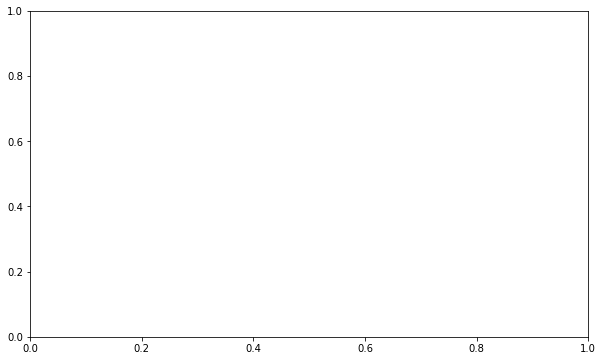

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=tpm_df.loc[tpm_df.gene.isin(clades[6])],
             x='stageName', 
             y='tpm', 
             sort=False,
             hue='gene',
             palette='flare',
             lw=1.5,
             ax=ax)
plt.show()